In [79]:
import sys

REPO_PATH = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline" # Specify a local path to the repository (or use installed package instead)
sys.path.append(REPO_PATH)

from models.mlp import Mlp, mlp_data_preparation
from models.lstm import Lstm, lstm_data_preparation

import numpy as np
from data.test_train_split import test_train_split
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from models.utils import save_weight_statistics, load_weight_statistics, pen_low_loss
import wandb


#### Data preparation

In [2]:

dataset_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_60_buckets_9_bands_60_dataset.npy"   
labels_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_60_buckets_9_bands_60_labels.npy"

config_data = {
    "months": 3,
    "num_bands": 12,
    "num_buckets": 60,
    "batch_size": 32,
}

#### MLP

In [20]:
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
mlp_train_dataset, mlp_val_dataset, mlp_test_dataset = test_train_split(mlp_dataset,
                                                            labels,
                                                            **config_data)

In [67]:
mlp_dataset.shape


(6913, 1620)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Epoch 1/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12405.1572 - mae: 89.8583 - mse: 11513.1172 - val_loss: 1947.7703 - val_mae: 32.4276 - val_mse: 1584.6604
Epoch 2/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1772.4698 - mae: 28.8446 - mse: 1318.4229 - val_loss: 1436.8997 - val_mae: 21.8130 - val_mse: 774.3640
Epoch 3/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1254.1085 - mae: 23.3280 - mse: 899.0912 - val_loss: 1058.4249 - val_mae: 21.5579 - val_mse: 751.2622
Epoch 4/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1099.0437 - mae: 21.3513 - mse: 755.0038 - val_loss: 1352.6119 - val_mae: 27.3712 - val_mse: 1252.4044
Epoch 5/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1188.8590 - mae: 22.7080 - mse: 883.2047 - val_loss: 833.5665 - val_mae: 19.1797 - val_mse: 625.1498
Epoch 6/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 879.4204 - mae: 19.1253 - mse: 643.6740 - val_loss: 988.0239 - val_mae: 21.9735 - val_mse: 867.1378
Epoch 7/150
138/138

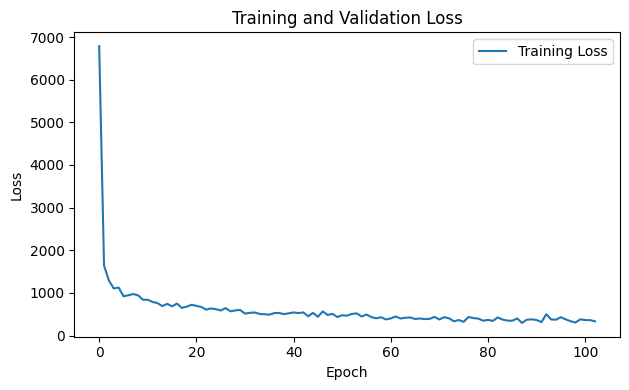

In [80]:
wandb.init(project="blue-marble")

mlp_config = {
    "input_shape": (9 * 60 * 3),
    "no_units": [100,] * 5,
}
mlp_model = Mlp(**mlp_config)
mlp_model.compile(learning_rate=0.0003, loss=pen_low_loss, metrics=["mae", "mse"])
mlp_model.fit(mlp_train_dataset,
         mlp_val_dataset,
         epochs=150)

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model.trainable = False
wandb.finish()  

In [114]:
mlp_eval = mlp_model.evaluate(mlp_test_dataset)
print(mlp_eval)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.2711 - mae: 7.9629 - mse: 185.4287
[313.0845947265625, 8.035999298095703, 189.95143127441406]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


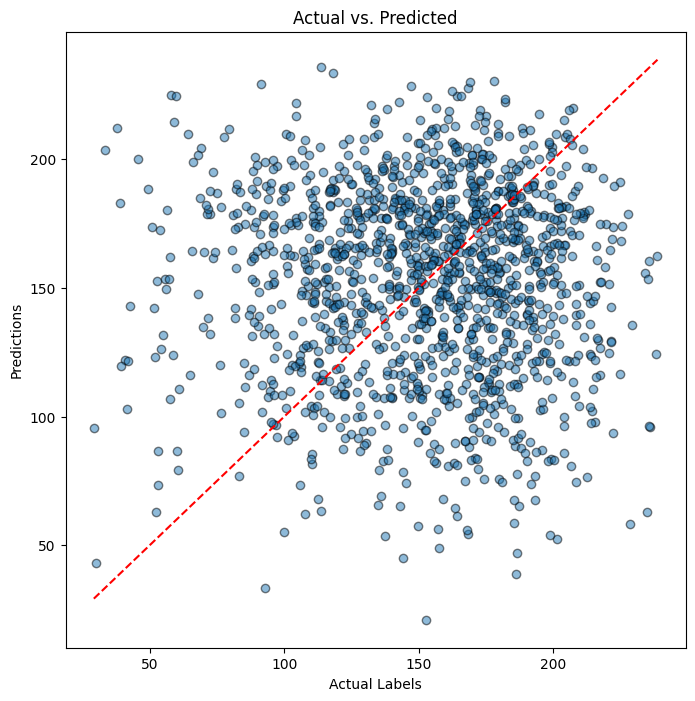

In [84]:
mlp_predictions = mlp_model.predict(mlp_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in mlp_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [86]:
test_responses = []
for _, response in mlp_test_dataset:
    test_responses.append(response.numpy())

test_responses = np.concatenate(test_responses, axis=0)

mean_train_response = tf.reduce_mean([y for _, y in mlp_train_dataset]).numpy()

baseline_loss = sum(((mean_train_response - test_responses) ** 2)/len(test_responses))
print(sum(baseline_loss))


1499.70458984375


#### LSTM

In [3]:
lstm_dataset, labels = lstm_data_preparation(dataset_path, labels_path)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = test_train_split(lstm_dataset,
                                                                            labels,
                                                                            **config_data)

Epoch 1/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 21210.4629 - mae: 139.9639 - val_loss: 16154.0586 - val_mae: 121.4202
Epoch 2/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 14788.7832 - mae: 115.1015 - val_loss: 12055.6416 - val_mae: 103.0653
Epoch 3/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 11044.1475 - mae: 97.9995 - val_loss: 8962.0898 - val_mae: 86.9452
Epoch 4/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8468.9004 - mae: 84.4597 - val_loss: 6788.6699 - val_mae: 74.1788
Epoch 5/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6419.0835 - mae: 72.0943 - val_loss: 5169.0186 - val_mae: 63.0792
Epoch 6/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4758.7114 - mae: 60.8608 - val_loss: 3945.5188 - val_mae: 54.5264
Epoch 7/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3590.9182 - mae: 51.7556 - val_loss: 3077.9573 - val_mae: 47.2941
Epoch 8/300
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2905.4456 - mae: 46.2779 - val_l

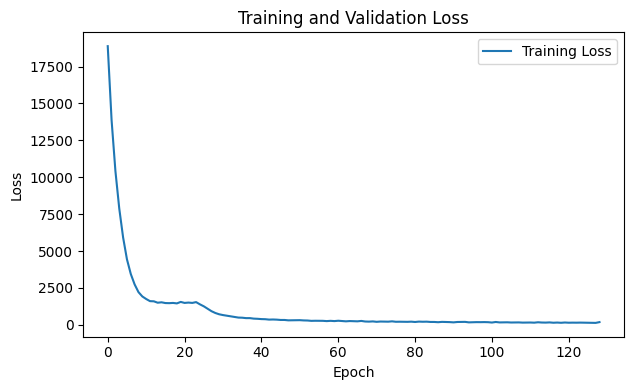

In [82]:
wandb.init(project="blue-marble")
config_lstm = {
    "input_shape": (3, 9 * 60),
    "no_lstm_units": [130,] * 7,
}
lstm_model = Lstm(**config_lstm)
lstm_model.compile(learning_rate=0.0008)
lstm_model.fit(lstm_train_dataset,
         lstm_val_dataset,
         epochs=300)

lstm_model.trainable = False
wandb.finish()

In [113]:
lstm_eval = lstm_model.evaluate(lstm_test_dataset)
print(lstm_eval)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 147.1162 - mae: 7.4710
[125.72661590576172, 7.051328659057617]


#### Comparison MLP vs LSTM

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


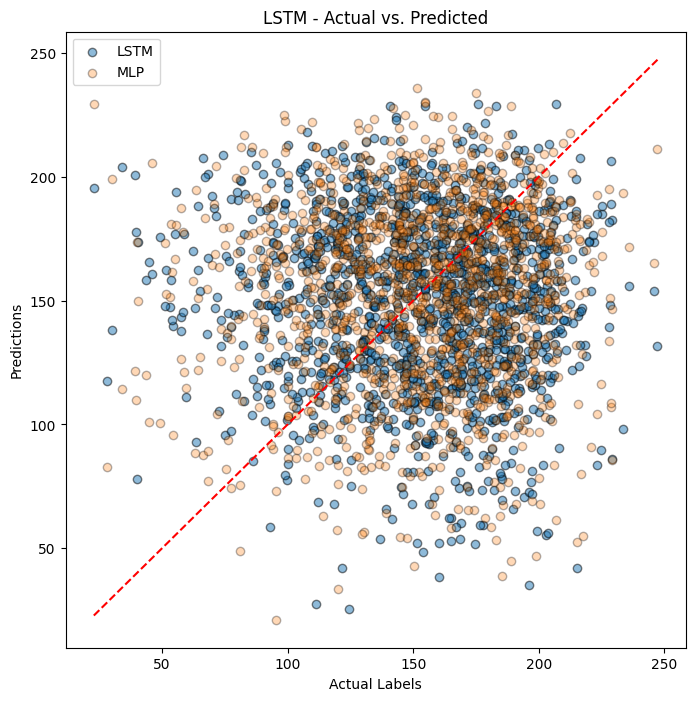

In [90]:
lstm_predictions = lstm_model.predict(lstm_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in lstm_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lstm_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(actual_labels, mlp_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

In [103]:
# loss below treshold
low_yield_treshold = 100
low_yeild_mask = actual_labels < low_yield_treshold

mlp_mse_low = sum((mlp_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
lstm_mse_low = sum((lstm_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)

print(f"MLP RMSE low yield: {np.sqrt(mlp_mse_low)}")
print(f"LSTM RMSE low yield: {np.sqrt(lstm_mse_low)}")


MLP RMSE low yield: 26.188820686757612
LSTM RMSE low yield: 26.446741247146967


Comment: 
* Right now MLP has an advantage of being more flexible and works with penalised loss on low yields data

* Potential further improvement could come from data augmentation


#### LSTM investigation

In [8]:
lstm_model.model_name

'LSTM-weary-beer-20241031-230908'

In [ ]:
import tensorflow as tf
import json

def inspect_keras_model(path):
    # Load the model
    model = tf.keras.models.load_model(path)
    
    print("\n=== Basic Model Info ===")
    print(f"Number of layers: {len(model.layers)}")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")
    
    print("\n=== Model Summary ===")
    model.summary()
    
    print("\n=== Detailed Layer Info ===")
    for layer in model.layers:
        print(f"\nLayer: {layer.name}")
        print(f"  Type: {type(layer).__name__}")
        print(f"  Input shape: {layer.input_shape}")
        print(f"  Output shape: {layer.output_shape}")
        print(f"  Trainable: {layer.trainable}")
        print(f"  Number of weights: {len(layer.weights)}")
        
        # Print weight details
        if layer.weights:
            print("  Weights:")
            for weight in layer.weights:
                print(f"    {weight.name}: shape {weight.shape}")
    
    print("\n=== Optimizer Info ===")
    if model.optimizer:
        print(f"Optimizer: {type(model.optimizer).__name__}")
        print("Optimizer config:")
        print(json.dumps(model.optimizer.get_config(), indent=2))
    
    print("\n=== Compilation Info ===")
    if hasattr(model, 'loss'):
        print(f"Loss: {model.loss}")
    if hasattr(model, 'metrics'):
        print(f"Metrics: {model.metrics}")

lstm_model.name
model_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\{lstm_model.model_name}.keras"
inspect_keras_model(model_path)

In [10]:
model = tf.keras.models.load_model(model_path)

In [11]:
def inspect_weight_statistics(model):
    for layer in model.layers:
        if layer.weights:
            print(f"\nLayer: {layer.name}")
            for weight in layer.weights:
                values = weight.numpy()
                print(f"\nWeight: {weight.name}")
                print(f"Shape: {values.shape}")
                print(f"Mean: {np.mean(values):.6f}")
                print(f"Std: {np.std(values):.6f}")
                print(f"Min: {np.min(values):.6f}")
                print(f"Max: {np.max(values):.6f}")
                # Check if weights follow specific distribution
                print("Distribution characteristics:")
                if np.abs(np.mean(values)) < 0.1 and 0.4 < np.std(values) < 0.8:
                    print("  Possibly Glorot/Xavier initialization")
                elif np.abs(np.mean(values)) < 0.1 and np.std(values) < 0.4:
                    print("  Possibly He/Kaiming initialization")

In [12]:
inspect_weight_statistics(lstm_model)


Layer: lstm_1

Weight: kernel
Shape: (540, 440)
Mean: 0.000968
Std: 0.134310
Min: -1.047605
Max: 0.942149
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (110, 440)
Mean: -0.000418
Std: 0.160613
Min: -0.988930
Max: 1.121738
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (440,)
Mean: 0.266560
Std: 0.432170
Min: -0.231943
Max: 1.232651
Distribution characteristics:

Layer: lstm_2

Weight: kernel
Shape: (110, 440)
Mean: -0.001006
Std: 0.170689
Min: -0.774974
Max: 0.835811
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (110, 440)
Mean: -0.000890
Std: 0.116206
Min: -0.681109
Max: 0.615305
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (440,)
Mean: 0.208311
Std: 0.425549
Min: -0.336598
Max: 1.111011
Distribution characteristics:

Layer: lstm_3

Weight: kernel
Shape: (110, 440)
Mean: -0.000897
Std: 0.172648


In [13]:
lstm_weights_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights"
save_weight_statistics(lstm_model, lstm_weights_path)

Weight statistics saved to: C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights/weight_stats_LSTM-weary-beer-20241031-230908_20241031-233034.json


{'model_name': 'LSTM-weary-beer-20241031-230908',
 'timestamp': '20241031-233034',
 'layers': [{'layer_name': 'lstm_1',
   'layer_type': 'LSTM',
   'weights': [{'weight_name': 'kernel',
     'shape': [540, 440],
     'statistics': {'mean': 0.0009684133692644536,
      'std': 0.13431040942668915,
      'min': -1.0476053953170776,
      'max': 0.9421489238739014,
      'median': 0.0011091433698311448,
      'quartiles': [-0.08583041653037071, 0.08747386559844017]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'recurrent_kernel',
     'shape': [110, 440],
     'statistics': {'mean': -0.00041752035031095147,
      'std': 0.16061250865459442,
      'min': -0.9889298677444458,
      'max': 1.1217381954193115,
      'median': 0.0006034302059561014,
      'quartiles': [-0.10405119322240353, 0.10277333669364452]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'bias',
     'shape': [440],
     'statistics': {'mean': 0.266560435295105,
      'std': 0.43216

In [ ]:
load_weight_statistics